<a href="https://colab.research.google.com/github/nicholasproietti/LGM/blob/main/LC_FFT_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP trained on Lightcruves

---



### Install the lightkurve libary and import the necessary packages

In [1]:
!pip install lightkurve

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 259 kB 5.1 MB/s 
     |████████████████████████████████| 4.5 MB 35.6 MB/s 
     |████████████████████████████████| 98 kB 4.3 MB/s 
     |████████████████████████████████| 41 kB 102 kB/s 
     |████████████████████████████████| 11.2 MB 27.0 MB/s 
     |████████████████████████████████| 885 kB 72.7 MB/s 
     |████████████████████████████████| 48 kB 3.6 MB/s 
     |████████████████████████████████| 4.0 MB 36.1 MB/s 
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11376 sha256=9bad257b343fdbb7be3746d9518af94d9f3c0be10a527c0a96bc1d856a9015f9
  Stored in directory: /root/.cache/pip/wheels/b4/3b/77/a06a07a415b222f47a7e522333f85ce64c0defd07a57762267
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50467 sha256=9660fec9f0b740d428a6cd2b4897cf088ed77c71d6777b48fedde6b43b249af7
  Stored in directory: /root/.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightkurve as lk
import scipy
from scipy.fft import fft, fftfreq
from scipy import signal
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from scipy.fft import fft, ifft
from sklearn.preprocessing import normalize

### Read the KOI.csv file into a data frame and select only the CONFIRMED candidates

In [2]:
#KOI_first_100 = pd.read_csv('KIC_first_100.csv')
KOI = pd.read_csv('KOI.csv')
KOI.drop(KOI.columns[0], axis=1, inplace=True)
KOI = KOI.drop(KOI[KOI['koi_disposition']!='CONFIRMED'].index)
KOI = KOI[KOI['koi_prad'].notna()]
KOI.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,0.43,0.94,-0.00020,-0.00055,-0.01,0.20,0.20,0.08,0.31,0.32
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,...,-0.63,1.23,0.00066,-0.00105,0.39,0.00,0.39,0.49,0.12,0.50
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,-0.01,0.23,0.00008,-0.00007,0.03,-0.09,0.10,0.07,0.02,0.07
5,10872983,K00756.01,Kepler-228 d,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,-0.12,0.14,0.00004,NaN,0.04,-0.07,0.08,-0.02,-0.08,0.08
6,10872983,K00756.02,Kepler-228 c,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,0.14,-0.32,-0.00016,NaN,0.25,0.09,0.26,0.18,0.06,0.19


A sample light curve would look like this

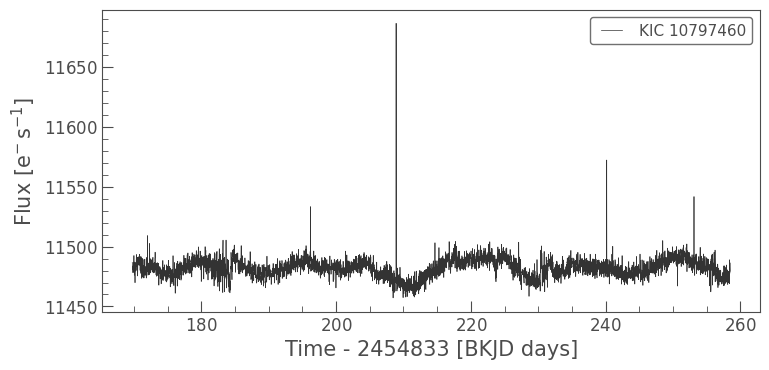

In [6]:
search_result_q2 = lk.search_lightcurve('KIC ' + str(KOI['kepid'][0]), author='Kepler', quarter=2)
lc = search_result_q2.download()
lc = lc.fill_gaps()
lc.plot()

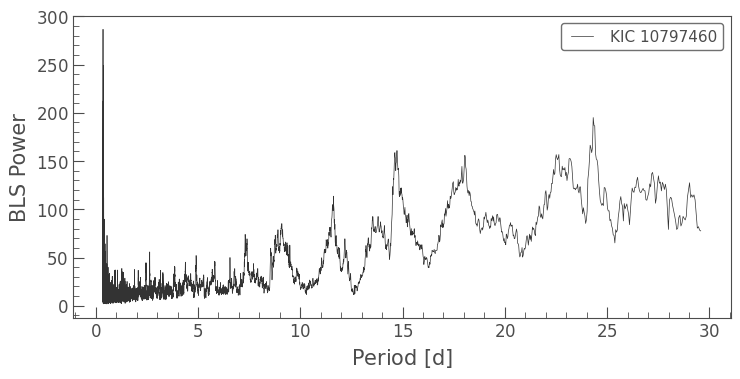

In [7]:
f = lc['flux'].value
t = lc['time'].value
periodogram = lc.to_periodogram(method='bls')
periodogram.plot()

For each light curve its Fourier Transform is computed. As stellar activity is the dominant part of the light curve initial frequencies in the Fourier transform can be set to zero. Then we compute the inverse fourier transform to get the filtered light curve

Text(0, 0.5, 'Flux')

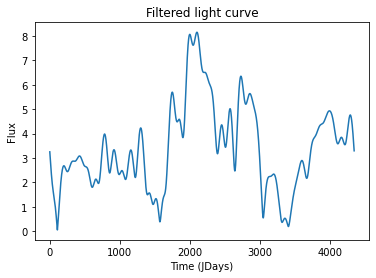

In [8]:
s = fft(f)
s[:4300] = 0
f_cleared = np.abs(ifft(s))
plt.plot(f_cleared)
plt.title('Filtered light curve')
plt.xlabel('Time (JDays)')
plt.ylabel('Flux')

#FFT

In [13]:
outlier_size = 41820
outlier_size_threshold = 4075
flux = np.empty([4075,])
print(flux)
time = np.empty([4075,])
outlier = -1
download_failed_index = []
radius = []
duration = []
for index, rad in zip(KOI.T, KOI['koi_prad']):
  try:
    search_result_q2 = lk.search_lightcurve('KIC ' + str(row['kepid']), author='Kepler', quarter=2)
    lc = search_result_q2.download()
    lc = lc.fill_gaps(method='gaussian_noise')
    flux_small = lc['flux'].value
    time_small = lc['time'].value
    y = np.abs(fft(flux_small))
    #y[:300] = 0
    f_cleared = y
    #f_cleared = np.abs(ifft(y))
    #periodogram = lc.to_periodogram(method='bls')
    #power = periodogram.power.to_value()
    #period = periodogram.period.to_value()
    if f_cleared.size > outlier_size_threshold:
      outlier = index
      f_cleared = f_cleared[:outlier_size_threshold]
      time_small = time_small[:outlier_size_threshold]

    flux = np.vstack((flux, f_cleared))
    time = np.vstack((time, time_small))
    radius.append(rad)
    duration.append(dur)
  except:
    download_failed_index.append(index)

[7.7175552e-316 2.4550030e+006 2.4550030e+006 ... 2.4550910e+006
 2.4550910e+006 2.4550910e+006]


In [10]:
flux = flux[1:]
time = time[1:]

array([5.63532066e-317, 1.36623973e-319,             nan, ...,
       6.90256067e-310, 6.90247028e-310, 6.90247018e-310])

## Having a problem splitting the DF for CNN training

In [5]:
# X, y = df['Flux'].to_numpy(np.float32), df['Radius'].to_numpy(np.float32)

#X, y = flux, KOI['koi_prad'].to_numpy(np.float64)

from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#scaler.fit(X, y)
#normalized = scaler.transform(X, y)
#inverse = scaler.inverse_transform(nromalized)


X, y, duration = flux, np.array(radius), np.array(duration)

X = tf.keras.utils.normalize(X, axis=1, order=2)

#y = np.delete(y, download_failed_index)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

for i in range(len(X_train)):
  X_mean = np.mean(X_train[i])
  X_std = np.std(X_train[i])
  X_train_man_std = (X_train[i] - X_mean) / X_std
  X_train[i] = X_train_man_std

for i in range(len(X_test)):
  X_mean = np.mean(X_test[i])
  X_std = np.std(X_test[i])
  X_test_man_std = (X_test[i] - X_mean) / X_std
  X_test[i] = X_test_man_std

for i in range(len(X_train)):
  X_max = np.max(X_train[i])
  X_min = np.min(X_train[i])
  X_train_man_norm = (X_train[i] - X_min) / (X_max - X_min)
  X_train[i] = X_train_man_norm

for i in range(len(X_test)):
  X_max = np.max(X_test[i])
  X_min = np.min(X_test[i])
  X_test_man_norm = (X_test[i] - X_min) / (X_max - X_min)
  X_test[i] = X_test_man_norm

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

# X_train, X_test, y_train, y_test, X_val, y_val = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test), np.array(X_val), np.array(y_val)

/usr/local/lib/python3.8/dist-packages/numpy/linalg/linalg.py:2560: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


AxisError: ignored

In [169]:
len(X_train)

1974

In [173]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean abs error')
  plt.plot(history.epoch, np.array(history.history['mae']),
           label='Train')
  #plt.plot(history.epoch, np.array(history.history['val_mae']),
  #         label='Val')
  plt.title('MAE vs Epochs')
  #plt.legend()
  #plt.ylim([0, max(history.history['val_mae'])])

def plot_prediction(test_labels, test_predictions):
  plt.figure()
  plt.scatter(test_labels, test_predictions)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.axis('equal')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  _ = plt.plot([-100, 100], [-100, 100])
  
  plt.figure()
  error = test_predictions - test_labels
  plt.hist(error, bins = 50)
  plt.xlabel('Prediction Error')
  _ = plt.ylabel('Count')

In [204]:
def build_model():
  model = keras.Sequential([
      keras.layers.Input(shape=X_train.shape[1]),
      keras.layers.Dense(64, activation=tf.nn.relu),
      keras.layers.Dense(1)
  ], name='MLP_model')

  optimizer = tf.keras.optimizers.RMSprop(0.0001)
  #optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

  model.compile(loss='mse', 
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

Model: "MLP_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 64)                260864    
                                                                 
 dense_39 (Dense)            (None, 1)                 65        
                                                                 
Total params: 260,929
Trainable params: 260,929
Non-trainable params: 0
_________________________________________________________________


In [205]:
EPOCHS = 500
batch_size = 32
# Store training stats

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=EPOCHS, validation_split=0.2, verbose=1)

Epoch 1/500
50/50 [==============================] - 1s 12ms/step - loss: 18.0178 - mae: 2.7125 - val_loss: 19.4550 - val_mae: 2.6037
Epoch 2/500
50/50 [==============================] - 0s 8ms/step - loss: 17.7160 - mae: 2.6568 - val_loss: 19.1919 - val_mae: 2.5526
Epoch 3/500
50/50 [==============================] - 0s 10ms/step - loss: 17.4535 - mae: 2.6059 - val_loss: 18.9357 - val_mae: 2.5020
Epoch 4/500
50/50 [==============================] - 0s 9ms/step - loss: 17.1851 - mae: 2.5544 - val_loss: 18.6689 - val_mae: 2.4481
Epoch 5/500
50/50 [==============================] - 0s 9ms/step - loss: 16.9121 - mae: 2.5002 - val_loss: 18.4096 - val_mae: 2.3945
Epoch 6/500
50/50 [==============================] - 0s 9ms/step - loss: 16.6357 - mae: 2.4449 - val_loss: 18.1367 - val_mae: 2.3369
Epoch 7/500
50/50 [==============================] - 0s 9ms/step - loss: 16.3563 - mae: 2.3869 - val_loss: 17.8655 - val_mae: 2.2781
Epoch 8/500
50/50 [==============================] - 0s 8ms/step - 

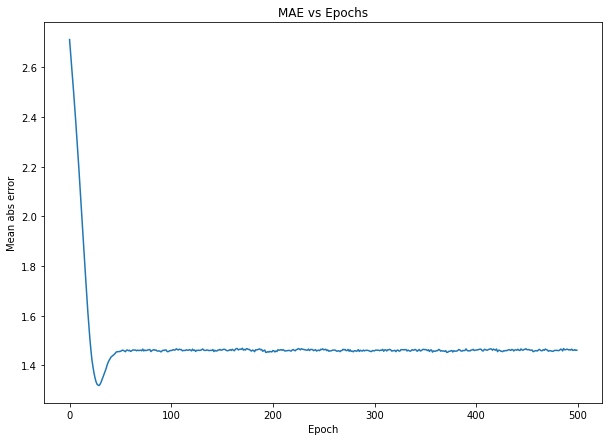

In [206]:
plot_history(history)

In [207]:
[loss, mae] = model.evaluate(X_test, y_test, verbose=0)
print("Testing set Mean Abs Error: {:7.2f}".format(mae))

Testing set Mean Abs Error:    1.59


In [208]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [210]:
model.evaluate(X_test, y_test, verbose=0)
print(model.predict_on_batch(X_test))
print(y_test)

[[2.767686 ]
 [2.7674327]
 [2.7696278]
 [2.7690387]
 [2.7659028]
 [2.7641072]
 [2.7699027]
 [2.7667847]
 [2.7685747]
 [2.767662 ]
 [2.7686672]
 [2.768073 ]
 [2.769401 ]
 [2.764142 ]
 [2.768885 ]
 [2.7693775]
 [2.7666273]
 [2.7667465]
 [2.7676775]
 [2.7660456]
 [2.7665384]
 [2.7689605]
 [2.7690105]
 [2.7663345]
 [2.7686167]
 [2.764945 ]
 [2.7678375]
 [2.7685509]
 [2.768773 ]
 [2.7651696]
 [2.7683775]
 [2.7674522]
 [2.7651818]
 [2.7676258]
 [2.7703328]
 [2.7674356]
 [2.7668638]
 [2.764019 ]
 [2.770809 ]
 [2.7725103]
 [2.7712426]
 [2.7687721]
 [2.7658513]
 [2.7652311]
 [2.770873 ]
 [2.7667065]
 [2.7668383]
 [2.7660887]
 [2.7682717]
 [2.7645857]
 [2.766283 ]
 [2.7657957]
 [2.7643607]
 [2.7676616]
 [2.7637792]
 [2.7674868]
 [2.766071 ]
 [2.7703707]
 [2.7690175]
 [2.7678251]
 [2.7691917]
 [2.7693386]
 [2.7645698]
 [2.764255 ]
 [2.7656686]
 [2.767457 ]
 [2.7629354]
 [2.7677786]
 [2.7661736]
 [2.7670174]
 [2.7667208]
 [2.7653065]
 [2.7697875]
 [2.7693155]
 [2.7705715]
 [2.7664323]
 [2.7679596]

In [89]:
def test_validate1(x_test, y_test, y_predict, classifier):
    x = range(len(y_test))
    #y_test = y_test.to_numpy()
    per_error = [abs(i-j)/i*100 if i != 0 else None for i,j in zip(y_test,y_predict)]
    #plt.plot(x, y_test, "ro", markersize=5, zorder=3, label=u"known")
    plt.plot(x, per_error, "bo", markersize=6, zorder=2, label=u"=%.3f" % classifier.score(x_test, y_test))
    #plt.plot(x, per_error, "bo", markersize=6, zorder=2)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=3, label="0% error")
    plt.legend(loc="upper left", prop={'size': 14})
    plt.xlabel("Exoplanet Sample Index", fontsize = 14)
    plt.ylabel("Radii Percent Error (%)", fontsize = 14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=14)
    #plt.axis([0, len(per_error), -10, np.max(per_error)])
    plt.title("Accuracy of MLPRegressor Exoplanet Radii Predictions (Validation Set)", fontsize = 14)
    print(len(per_error))
    plt.show()

def test_validate2(x_test, y_test, y_predict, classifier):
    x = range(len(y_test))
    plt.plot(x, y_test, "ro", markersize=5, zorder=3, label=u"known")
    plt.plot(x, y_predict, "bo", markersize=8, zorder=2, label=u"predicted, =%.3f" % classifier.score(x_test, y_test))
    #plt.plot(x, y_predict, "bo", markersize=8, zorder=2)
    plt.legend(loc="lower left", prop={'size': 14})
    plt.xlabel("Planet Sample Index", fontsize = 14)
    plt.ylabel("Planet Radius R$_{Earth}$", fontsize = 14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=14)
    #plt.axis([0, 100, 50,150])
    plt.show()

plt.rcParams["figure.figsize"] = (10,7)

In [90]:
#r = model.score(X_train, y_train)
y_predict = model.predict(X_test)
test_validate1(x_test=X_test, y_test=y_test, y_predict=y_predict, classifier=model)

16/16 [==============================] - 0s 3ms/step


AttributeError: ignored

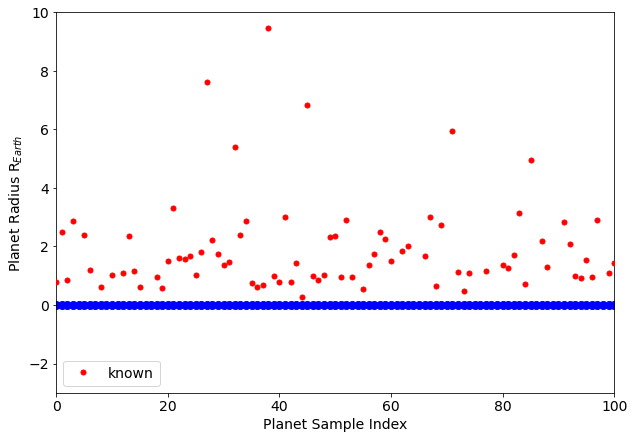

In [385]:
test_validate2(x_test=X_test, y_test=y_test, y_predict=y_predict, classifier=model)

In [211]:
from sklearn import neural_network
flux[0]

array([4.80492382e+08, 1.71579088e+04, 5.46059145e+04, ...,
       1.19453238e+04, 1.53558747e+03, 2.13253766e+03])

494


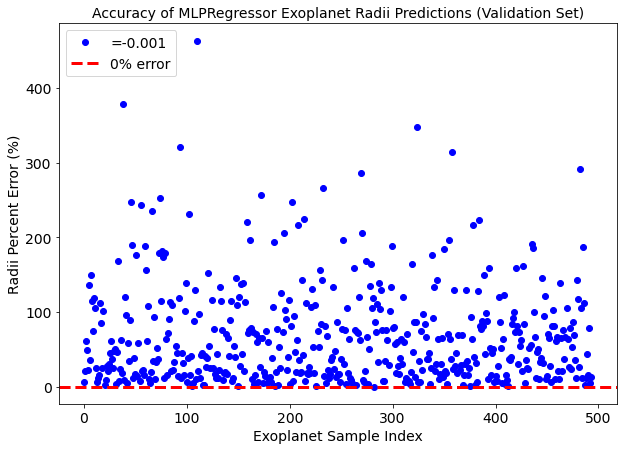

In [212]:
mlp = neural_network.MLPRegressor(hidden_layer_sizes=(100, 20), activation="relu",
                 solver='adam', alpha=0.0001,
                 batch_size='auto', learning_rate="constant",
                 learning_rate_init=0.001,
                 power_t=0.5, max_iter=1000,tol=1e-4)

mlp.fit(X_train, y_train)
r = mlp.score(X_train, y_train)
y_predict = mlp.predict(X_test)  
test_validate1(x_test=X_test, y_test=y_test, y_predict=y_predict, classifier=mlp)

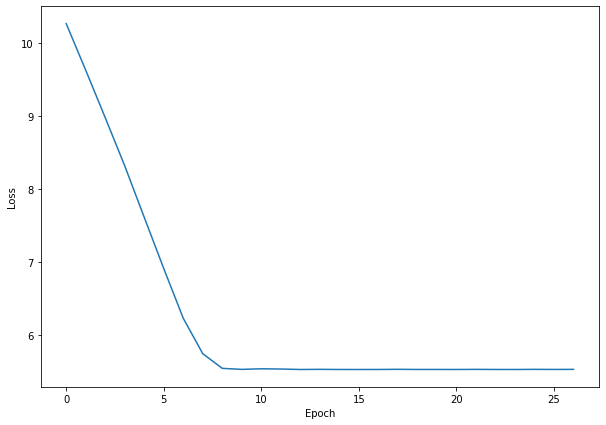

In [213]:
pd.DataFrame(mlp.loss_curve_).plot(xlabel="Epoch", ylabel="Loss", legend=False)

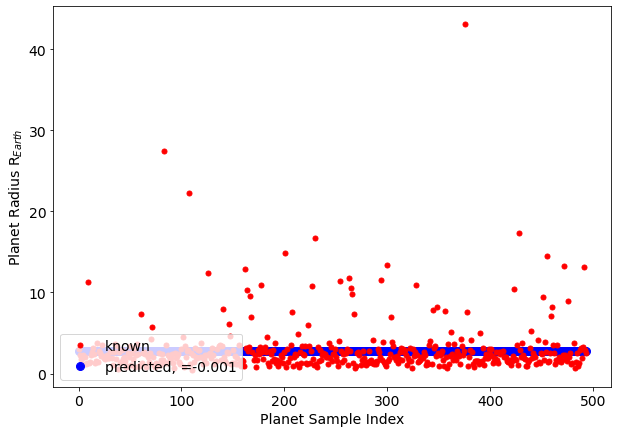

In [214]:
test_validate2(x_test=X_test, y_test=y_test, y_predict=y_predict, classifier=mlp)

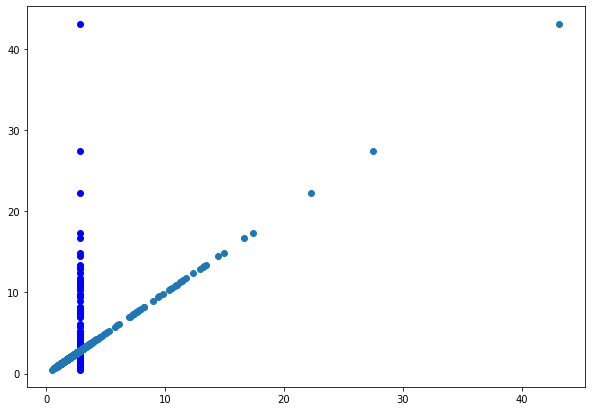

In [215]:
plt.scatter(y_predict, y_test, c='b')
plt.scatter(y_test, y_test)

In [216]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, duration, y_train)

LinearRegression()

In [218]:
y_pred = model.predict(X_test)

array([ 6.40840041e+00, -1.45031383e+01,  8.48981729e+00,  1.14889381e+01,
        4.77933786e+00, -1.06486535e+00,  1.63245816e+00, -3.67004862e+00,
        1.11713813e+01, -1.02748314e-01,  9.45088942e+00,  1.38719133e+00,
        1.47766814e+01, -1.36410004e+00,  4.09685207e+00,  1.62080206e+00,
        4.71223520e+00, -6.26595362e+00, -3.29008293e+00,  3.67239142e+00,
        2.61409438e+00, -5.01281653e+00,  1.29405528e+01,  2.02987109e+01,
        3.82362701e+00, -6.60356941e+00, -4.12580888e+00, -1.01274510e+01,
       -7.68556062e+00, -6.49307916e+00,  3.37980575e+00, -5.98161544e-01,
       -1.07507041e+01,  1.76971311e+01, -4.72344441e+00, -5.47013216e+00,
       -3.10541842e+00,  3.25366059e-01, -3.25250838e+00,  2.89291797e+00,
        1.42521342e+01,  9.02447177e+00,  8.75393804e+00,  1.52051915e+01,
       -4.19602044e+00, -8.98133406e+00,  1.20658165e+01, -1.76458113e+01,
        1.16414103e+01, -1.13370449e+00, -7.95125613e+00,  1.12437716e+01,
        1.63746413e+00,  

In [ ]:
plt.plot(y_pred, y_pred)
plt.plot(y_test, )